In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_discrimination (df, sensitive_attributes, class_name):

# ASSUMPTION: Each value of the attribute is discriminated
# For each value, we therefore apply the Preferential Sampling formulas to compute the discrimination 
# If discrimination > 0, the assumption holds true
# Otherwhise, it doesn't. This means the value is actually *privileged*
# A dictionary of sensitive attributes and values is created as such
#
# Please note the sum of records to add / remove for each priviliged value
# should be equal to the sum of records to add / removed for each discriminated value
#
# A rounding error is possible

    
    sensitive_dict = {}
    
    print ("Records:", len(df))
    
    tot_disc = 0
    tot_pos = 0
    
    #df = X_proba
    
    for attr in sensitive_attributes:
        print ()
        print ("Analizing", attr, "...")
        sensitive_dict[attr] = {}
        sensitive_dict[attr]['D'] = {}
        sensitive_dict[attr]['P'] = {}
        sensitive_dict[attr]['D']['values_list'] = []
        sensitive_dict[attr]['P']['values_list'] = []
        values = df[attr].unique()
        disc_vals = []
        priv_vals = []
        disc_perc = []
        priv_perc = []
        for val in values:
            PP = df[(df[attr] != val) & (df[class_name] == 1)].values.tolist()
            PN = df[(df[attr] != val) & (df[class_name] == 0)].values.tolist()
            DP = df[(df[attr] == val) & (df[class_name] == 1)].values.tolist()
            DN = df[(df[attr] == val) & (df[class_name] == 0)].values.tolist()

            disc = len(DN) + len(DP)
            priv = len(PN) + len(PP)
            pos = len(PP) + len(DP)
            neg = len(PN) + len(DN)
            
            DP_exp = round(disc * pos / len(df))
            PP_exp = round(priv * pos / len(df))
            DN_exp = round(disc * neg / len(df))
            PN_exp = round(priv * neg / len(df))
            
            discrimination = len(PP) / (len(PP) + len(PN)) - len(DP) / (len(DP) + len(DN))
       
            if discrimination >= 0:
                status = 'D'
                sensitive_dict[attr][status][val] = {}
                print("")
                print(val, "is discriminated")
                print("Local disc:", discrimination)
                
                sensitive_dict[attr][status][val]['P'] = DP
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp
                sensitive_dict[attr][status][val]['P_curr'] = len(DP)
                
                #for i in range(len(sensitive_dict[attr][status][val]['P'])):
                   # del sensitive_dict[attr][status][val]['P'][i][-1]
                                
                sensitive_dict[attr][status][val]['N'] = DN[0]
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp
                sensitive_dict[attr][status][val]['N_curr'] = len(DN)
                sensitive_dict[attr][status][val]['GD'] = 100 * (abs(len(DP)-DP_exp) + abs(len(DN)-DN_exp)) / len(df)

                #for i in range(len(sensitive_dict[attr][status][val]['N'])):
                    #del sensitive_dict[attr][status][val]['N'][i][-1]
                    
                print("Global disc:", sensitive_dict[attr][status][val]['GD'])

                print("- DP:", len(sensitive_dict[attr][status][val]['P']), '· Expected:', DP_exp, 
                      '· To be added:', abs(len(DP) - DP_exp))
                print("- DN:", len(sensitive_dict[attr][status][val]['N']), '· Expected:', DN_exp, 
                      '· To be removed:', abs(len(DN) - DN_exp))
                
                tot_disc = tot_disc + abs(len(DP) - DP_exp)
                                
                disc_vals.append(val)
                disc_perc.append(round(sensitive_dict[attr][status][val]['GD'], 2))
                

            else:
                status = 'P'
                sensitive_dict[attr][status][val] = {}
                print("")
                print(val, "is privileged")
                print("Local disc:", discrimination)                
                
                sensitive_dict[attr][status][val]['P'] = DP
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp
                sensitive_dict[attr][status][val]['P_curr'] = 0

                #for i in range(len(sensitive_dict[attr][status][val]['P'])):
                    #del sensitive_dict[attr][status][val]['P'][i][-1]
                    
                sensitive_dict[attr][status][val]['N'] = DN
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp
                sensitive_dict[attr][status][val]['N_curr'] = 0
                sensitive_dict[attr][status][val]['GD'] = 100 * (abs(len(DP)-DP_exp) + abs(len(DN)-DN_exp)) / len(df)


                #for i in range(len(sensitive_dict[attr][status][val]['N'])):
                    #del sensitive_dict[attr][status][val]['N'][i][-1]
                    
                print("Global disc:", sensitive_dict[attr][status][val]['GD'])
                
                print("- PP:", len(sensitive_dict[attr][status][val]['P']), '· Expected:', DP_exp, 
                      '· To be removed:', abs(len(DP) - DP_exp))
                print("- PN:", len(sensitive_dict[attr][status][val]['N']), '· Expected:', DN_exp, 
                      '· To be added:', abs(len(DN) - DN_exp))
                
                tot_pos = tot_pos + abs(len(DP) - DP_exp)
                
                priv_vals.append(val)
                priv_perc.append(round(sensitive_dict[attr][status][val]['GD'], 2))
            
            sensitive_dict[attr][status]['values_list'].append(val)
            
        
        attribute_disc = sum(priv_perc)
        print("")       
        print ("Global discrimination for", attr, attribute_disc)
        
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = ['Unbiased, ' + str(100 - round(attribute_disc, 2)) +"%",
        'Biased, ' + str(round(attribute_disc, 2)) +"%"]
        sizes = [100-attribute_disc, attribute_disc]
        patches, texts = plt.pie(sizes, startangle=90)
        plt.legend(patches, labels, loc="lower right")
        # Set aspect ratio to be equal so that pie is drawn as a circle.
        plt.axis('equal')
        plt.tight_layout()
        plt.title("Global Discrimination for " + str(attr))
        plt.show()
        

        
        for vals, percs, stat in zip((priv_vals, disc_vals), (priv_perc, disc_perc), 
                                    ('privileged', 'discriminated')):
            
            labels = ['Unbiased, ' + str(100-sum(percs)) +"%"]
            sizes = [100-sum(percs)]

            for val, perc in zip(vals, percs):
                labels = labels + [val + ", " + str(perc) +"%"]
                sizes = sizes + [perc]

            patches, texts = plt.pie(sizes, startangle=90)
            plt.legend(patches, labels, loc="lower right")
            # Set aspect ratio to be equal so that pie is drawn as a circle.
            plt.axis('equal')
            plt.tight_layout()
            plt.title(attr + " " + stat + " " + "values")
            plt.show()
        
    round_error = abs(tot_disc - tot_pos)

                                   
    return sensitive_dict            

In [3]:
df = pd.read_csv("adult.csv")
df['income'] = np.where(df['income'] == '>50K', 1, 0)

Records: 32561

Analizing race ...

White is privileged
Local disc: -0.10327827181663154
Global disc: 2.573631030987992
- PP: 7117 · Expected: 6698 · To be removed: 419
- PN: 20699 · Expected: 21118 · To be added: 419

Black is discriminated
Local disc: 0.12933909683724398
Global disc: 2.2419458861828567
- DP: 387 · Expected: 752 · To be added: 365
- DN: 15 · Expected: 2372 · To be removed: 365

Asian-Pac-Islander is privileged
Local disc: -0.02564892118366513
Global disc: 0.1597002549061761
- PP: 276 · Expected: 250 · To be removed: 26
- PN: 763 · Expected: 789 · To be added: 26

Other is discriminated
Local disc: 0.14980544169021745
Global disc: 0.24569269985565553
- DP: 25 · Expected: 65 · To be added: 40
- DN: 15 · Expected: 206 · To be removed: 40

Amer-Indian-Eskimo is discriminated
Local disc: 0.12625987686632267
Global disc: 0.23955038235926415
- DP: 36 · Expected: 75 · To be added: 39
- DN: 15 · Expected: 236 · To be removed: 39

Global discrimination for race 2.73


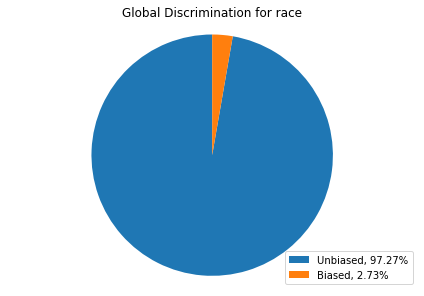

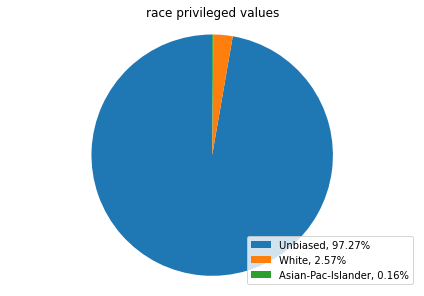

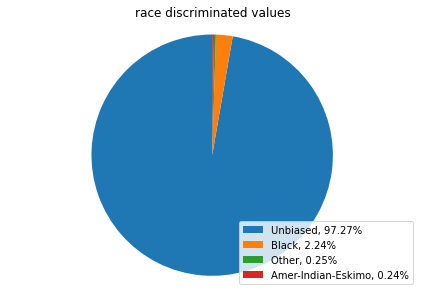


Analizing sex ...

Female is discriminated
Local disc: 0.19627598779361352
Global disc: 8.691379257393814
- DP: 1179 · Expected: 2594 · To be added: 1415
- DN: 15 · Expected: 8177 · To be removed: 1415

Male is privileged
Local disc: -0.19627598779361352
Global disc: 8.691379257393814
- PP: 6662 · Expected: 5247 · To be removed: 1415
- PN: 15128 · Expected: 16543 · To be added: 1415

Global discrimination for sex 8.69


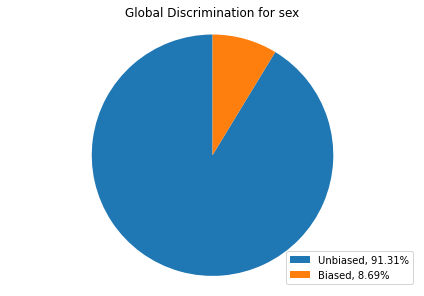

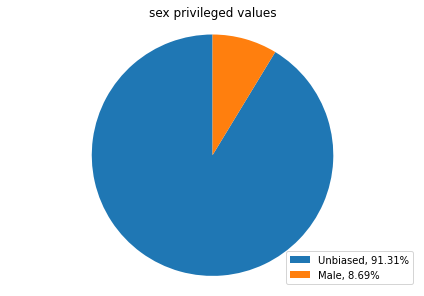

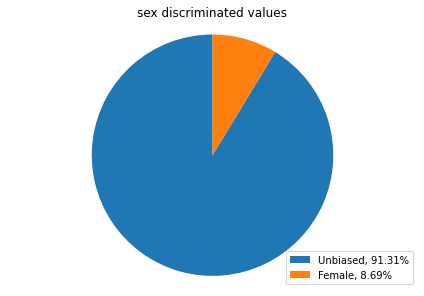

In [4]:
d = get_discrimination(df, ['race', 'sex'], 'income')